In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!unzip gdrive/My\ Drive/digipath/ki-67-patches-dataset.zip

Archive:  gdrive/My Drive/digipath/ki-67-patches-dataset.zip
replace Ki-67-patches-dataset/images/test/63_105.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Ki-67-patches-dataset/images/test/63_105.png  
  inflating: Ki-67-patches-dataset/images/test/64_106.png  
  inflating: Ki-67-patches-dataset/images/test/64_107.png  
  inflating: Ki-67-patches-dataset/images/test/65_108.png  
  inflating: Ki-67-patches-dataset/images/test/65_109.png  
  inflating: Ki-67-patches-dataset/images/test/65_110.png  
  inflating: Ki-67-patches-dataset/images/test/65_111.png  
  inflating: Ki-67-patches-dataset/images/test/66_112.png  
  inflating: Ki-67-patches-dataset/images/test/66_113.png  
  inflating: Ki-67-patches-dataset/images/test/66_114.png  
  inflating: Ki-67-patches-dataset/images/test/67_115.png  
  inflating: Ki-67-patches-dataset/images/test/67_116.png  
  inflating: Ki-67-patches-dataset/images/test/67_117.png  
  inflating: Ki-67-patches-dataset/images/test/68_118.png  
  inf

In [ ]:
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 97.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.3 MB/s eta 0:00:00


In [ ]:
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import os
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
import pandas as pd
import cv2
import numpy as np
import albumentations as aug

In [ ]:
WIDTH = 384
HEIGHT = 384

In [ ]:
class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, root_dir, feature_extractor, transforms=None, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.train = train
        self.transforms = transforms

        sub_path = "train" if self.train else "test"
        self.img_dir = os.path.join(self.root_dir, "images", sub_path)
        self.ann_dir = os.path.join(self.root_dir, "segmentations", sub_path)

        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
            image_file_names.extend(files)
        self.images = sorted(image_file_names)

        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
            annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = cv2.imread(os.path.join(self.img_dir, self.images[idx]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image = cv2.resize(image, (HEIGHT, WIDTH))

        segmentation_map = cv2.imread(os.path.join(self.ann_dir, self.annotations[idx]))
        segmentation_map = cv2.cvtColor(segmentation_map, cv2.COLOR_BGR2GRAY)
        # segmentation_map = cv2.resize(segmentation_map, (HEIGHT, WIDTH))
#         image = Image.open()
#         segmentation_map = Image.open()

        if self.transforms is not None:
            augmented = self.transforms(image=image, mask=segmentation_map)
            # randomly crop + pad both image and segmentation map to same size
            encoded_inputs = self.feature_extractor(augmented['image'], augmented['mask'], return_tensors="pt")
        else:
            encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
            encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

In [ ]:
transform = aug.Compose([
    aug.Flip(p=0.5)
])

In [ ]:
root_dir = 'Ki-67-patches-dataset'
feature_extractor = SegformerFeatureExtractor(align=False, reduce_zero_label=False, size=(384,384))

train_dataset = ImageSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, transforms=transform)
valid_dataset = ImageSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, transforms=None, train=False)

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 105
Number of validation examples: 15


In [ ]:
encoded_inputs = train_dataset[23]

In [ ]:
encoded_inputs["pixel_values"].shape

torch.Size([3, 384, 384])

In [ ]:
encoded_inputs["labels"]

tensor([[  0,   0,   0,  ..., 125, 125, 125],
        [  0,   0,   0,  ..., 125, 125, 125],
        [  0,   0,   0,  ..., 125, 125, 125],
        ...,
        [  0,   0,   0,  ..., 255, 255, 255],
        [  0,   0,   0,  ..., 255, 255, 255],
        [  0,   0,   0,  ..., 255, 255, 255]])

In [ ]:
encoded_inputs["labels"].squeeze().unique()

tensor([  0, 125, 255])

In [ ]:
mask = encoded_inputs["labels"].numpy()

In [ ]:
import matplotlib.pyplot as plt

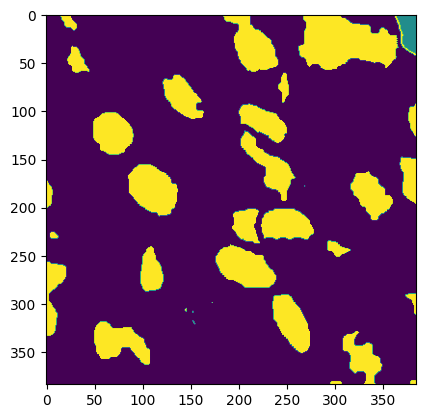

In [ ]:
plt.imshow(mask)

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=4)

In [ ]:
batch = next(iter(train_dataloader))

In [ ]:
for k,v in batch.items():
    print(k, v.shape)

pixel_values torch.Size([4, 3, 384, 384])
labels torch.Size([4, 384, 384])


In [ ]:
batch["labels"].shape

torch.Size([4, 384, 384])

In [ ]:
!pip install xlrd

In [ ]:
classes = pd.read_csv('/content/Ki-67-patches-dataset/class_dict_seg - class_dict_seg.csv')['name']
id2label = classes.to_dict()
label2id = {v: k for k, v in id2label.items()}

In [ ]:
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b5", ignore_mismatched_sizes=True,
                                                         num_labels=len(id2label), id2label=id2label, label2id=label2id,
                                                         reshape_last_stage=True)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.linear_c.1.proj.bias', 'decode_head.classifier.weight', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.3.proj.weight', 'decode_head.classifier.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.batch_norm.running_mean', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.bias', 'decode_head.linear_c.3.proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optimizer = AdamW(model.parameters(), lr=0.00006)
device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)
print("Model Initialized!")

Model Initialized!


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
print(batch["pixel_values"].shape)
print(batch["pixel_values"].device)


torch.Size([4, 3, 384, 384])
cpu


In [ ]:
print(model.device)


cuda:0


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Move the model to the desired device (GPU if available, otherwise CPU)
model = model.to(device)

# Move the entire batch (including "pixel_values" and "labels") to the desired device
batch = {key: value.to(device) for key, value in batch.items()}

# Now, all tensors in the batch, including "pixel_values" and "labels", are on the same device as the model.

# Rest of your code ...


RuntimeError: ignored

In [ ]:
import torch

print(torch.cuda.is_available())
print(torch.version.cuda)

True
11.8


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
batch = {key: value.to(device) for key, value in batch.items()}

RuntimeError: ignored

In [ ]:
for epoch in range(1, 11):  # loop over the dataset multiple times
    print("Epoch:", epoch)
    pbar = tqdm(train_dataloader)
    accuracies = []
    losses = []
    val_accuracies = []
    val_losses = []
    model.train()
    for idx, batch in enumerate(pbar):
        # get the inputs;
        if batch["pixel_values"].device == device:
            pixel_values = batch["pixel_values"]
        else:
            pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        labels[np.where(labels==0)]=0
        labels[np.where(labels==255)]=1
        labels[np.where(labels==125)]=2

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward

        outputs = model(pixel_values=pixel_values, labels=labels)


        # evaluate
        scale = torch.tensor(0.5)
        scale = torch.Tensor([(1 / scale)]).numpy().astype(np.float64)[0]
        upsampled_logits = nn.functional.interpolate(outputs.logits, mode="billinear", align_corners=False, scale_factor=scale)
        predicted = upsampled_logits.argmax(dim=1)

        mask = (labels) # we don't include the background class in the accuracy calculation
        pred_labels = predicted[mask].detach().numpy()
        true_labels = labels[mask].detach().numpy()
        accuracy = accuracy_score(pred_labels, true_labels)
        loss = outputs.loss
        accuracies.append(accuracy)
        losses.append(loss.item())
        pbar.set_postfix({'Batch': idx, 'Pixel-wise accuracy': sum(accuracies)/len(accuracies), 'Loss': sum(losses)/len(losses)})

        # backward + optimize
        loss.backward()
        optimizer.step()
    else:
        model.eval()
        with torch.no_grad():
            for idx, batch in enumerate(valid_dataloader):
                pixel_values = batch["pixel_values"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(pixel_values=pixel_values, labels=labels)
                upsampled_logits = nn.functional.interpolate(outputs, size=labels.shape[-2:], mode="bilinear", align_corners=False)
                predicted = upsampled_logits.argmax(dim=1)

                mask = (labels)
                pred_labels = predicted[mask].detach().cpu().numpy()
                true_labels = labels[mask].detach().cpu().numpy()
                accuracy = accuracy_score(pred_labels, true_labels)
                val_loss = outputs.loss
                val_accuracies.append(accuracy)
                val_losses.append(val_loss.item())

    print(f"Train Pixel-wise accuracy: {sum(accuracies)/len(accuracies)}\
         Train Loss: {sum(losses)/len(losses)}\
         Val Pixel-wise accuracy: {sum(val_accuracies)/len(val_accuracies)}\
         Val Loss: {sum(val_losses)/len(val_losses)}")

Epoch: 1


  0%|          | 0/27 [00:00<?, ?it/s]

RuntimeError: ignored